In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tqdm import tqdm
import pathlib
import random
import sys
import time
from PIL import Image
import math
import PIL

In [0]:
# import the ImageNet dataset
imgnet_data = tfds.load('imagenette/320px')

In [0]:
IMG_SIZE = 224
BATCH_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
train_data, test_data = imgnet_data['train'], imgnet_data['validation']
assert isinstance(train_data, tf.data.Dataset)
assert isinstance(test_data, tf.data.Dataset)

def augment(example):
  image = tf.image.random_crop(example['image'], size=IMG_SHAPE)
  image = image/255 # Scale the images so that they have pixel values between 0 and 1
  return image, example['label']

train_data = train_data.map(augment)
test_data = test_data.map(augment)

(224, 224, 3) tf.Tensor(2, shape=(), dtype=int64)


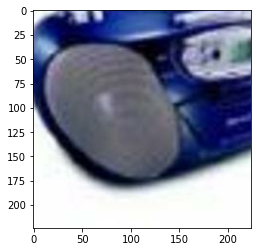

(224, 224, 3) tf.Tensor(6, shape=(), dtype=int64)


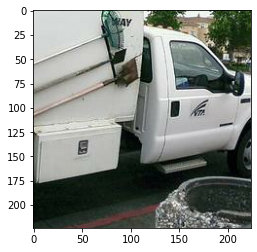

In [0]:
# Show first images
for image, label in train_data.take(2):
  print(image.shape, label)
  plt.imshow(image)
  plt.show()

In [0]:
# Batch the data
train_data = train_data.batch(BATCH_SIZE)
test_data = test_data.batch(BATCH_SIZE)

In [0]:
model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
"""# optimize weights on downscaled imagenet dataset
optim = tfa.optimizers.RectifiedAdam()
optim = tfa.optimizers.Lookahead(optim)

model.compile(optimizer=optim,
loss=tf.keras.losses.sparse_categorical_crossentropy,
metrics=["accuracy"])
model.fit(train_data, epochs=3)
model.evaluate(test_data)"""

'# optimize weights on downscaled imagenet dataset\noptim = tfa.optimizers.RectifiedAdam()\noptim = tfa.optimizers.Lookahead(optim)\n\nmodel.compile(optimizer=optim,\nloss=tf.keras.losses.sparse_categorical_crossentropy,\nmetrics=["accuracy"])\nmodel.fit(train_data, epochs=3)\nmodel.evaluate(test_data)'

In [0]:
pretrained = tf.keras.Model(model.inputs, [model.outputs, model.get_layer('block2_conv1').output, model.get_layer('block5_conv3').output])

In [0]:
earlyDeconvNet = tf.keras.Sequential([
                                      tf.keras.layers.InputLayer(input_shape=(112, 112, 128)),
                                      tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.UpSampling2D(2),
                                      tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu'),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Conv2DTranspose(3, 3, padding='same', activation='sigmoid'),
])

In [0]:
# functions for training here
mse = tf.keras.losses.LogCosh()
crossentropy = tf.keras.losses.SparseCategoricalCrossentropy()

def MSE_loss(model, x, y):
  y_ = model(x)
  return mse(y_true=y, y_pred=y_)

def CE_loss(model, x, y):
  y_ = model(x)[0]
  return crossentropy(y_true=y, y_pred=y_)

def grad(model, inputs, targets, loss):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [0]:
# Retune the VGG model
optimizer = tfa.optimizers.RectifiedAdam()
optimizer = tfa.optimizers.Lookahead(optimizer)

train_loss_results = []
train_accuracy_results = []

num_epochs = 3

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of BATCH_SIZE
  for x, y in tqdm(train_data):
    # Optimize the VGG model
    loss_value, grads = grad(pretrained, x, y, CE_loss)
    optimizer.apply_gradients(zip(grads, pretrained.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, pretrained(x)[0])

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 1 == 0:
    print(f"Epoch {epoch+1}: Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")

202it [02:56,  1.15it/s]
0it [00:00, ?it/s]

Epoch 1: Loss: 0.9050765633583069, Accuracy: 0.8093686699867249


202it [02:49,  1.19it/s]
0it [00:00, ?it/s]

Epoch 2: Loss: 0.4843194782733917, Accuracy: 0.91810142993927


202it [02:49,  1.19it/s]

Epoch 3: Loss: 0.4583934247493744, Accuracy: 0.9291143417358398


In [0]:
# Train the visualization model
optimizer = tfa.optimizers.RectifiedAdam()
optimizer = tfa.optimizers.Lookahead(optimizer)

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 5

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.MeanAbsoluteError()
  epoch_accuracy = tf.keras.metrics.MeanSquaredError()

  # Training loop - using batches of BATCH_SIZE
  for x, y in tqdm(train_data):
    # What to feed into our visualization network
    viz_input = pretrained(x)[1]

    # Optimize the visualization model
    loss_value, grads = grad(earlyDeconvNet, viz_input, x, MSE_loss)
    optimizer.apply_gradients(zip(grads, earlyDeconvNet.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(y_true=x, y_pred=earlyDeconvNet(viz_input))  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(x, earlyDeconvNet(viz_input))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 1 == 0:
    print(f"Epoch {epoch+1}: Loss: {epoch_loss_avg.result():.6f}, MSE: {epoch_accuracy.result():.6f}")

202it [03:37,  1.08s/it]
0it [00:00, ?it/s]

Epoch 1: Loss: 0.095650, MSE: 0.021


202it [03:35,  1.07s/it]
0it [00:00, ?it/s]

Epoch 2: Loss: 0.043835, MSE: 0.004


202it [03:36,  1.07s/it]
0it [00:00, ?it/s]

Epoch 3: Loss: 0.036667, MSE: 0.003


202it [03:36,  1.07s/it]
0it [00:00, ?it/s]

Epoch 4: Loss: 0.034028, MSE: 0.002


202it [03:36,  1.07s/it]

Epoch 5: Loss: 0.031922, MSE: 0.002


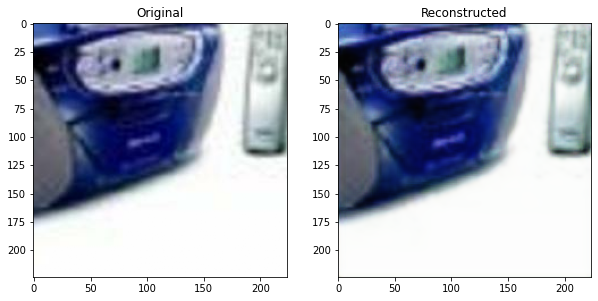

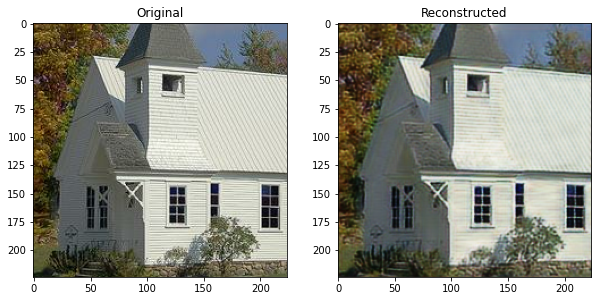

In [0]:
# Plot a couple reconstructions
for image, label in train_data.take(2):
  pretrain_out = pretrained(image)
  reconstruction = earlyDeconvNet(pretrain_out[1])
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.imshow(image[0, :, :, :])
  ax1.set_title('Original')
  ax2.imshow(reconstruction[0, :, :, :])
  ax2.set_title('Reconstructed')

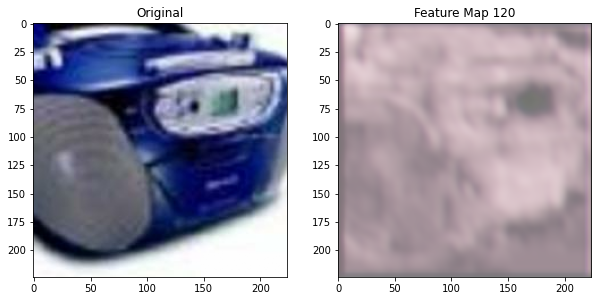

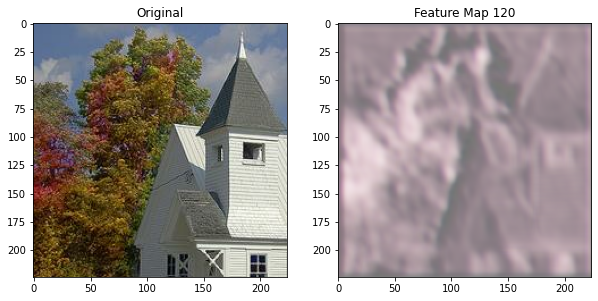

In [0]:
viz_channel = 120 # The feature we want to visualize

# Plot a couple feature visualizations
for image, label in train_data.take(2):
  pretrain_out = pretrained(image)[1]

  # Zero the other channels
  pretrain_out = pretrain_out.numpy()
  pretrain_out[:, :, :, 0:viz_channel] = 0
  pretrain_out[:, :, :, viz_channel+1:] = 0

  reconstruction = earlyDeconvNet(pretrain_out)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.imshow(image[0, :, :, :])
  ax1.set_title('Original')
  ax2.imshow(reconstruction[0, :, :, :])
  ax2.set_title(f'Feature Map {viz_channel}')

In [0]:
lateDeconvNet = tf.keras.Sequential([
                                     tf.keras.layers.InputLayer(input_shape=(14, 14, 512)),
                                     tf.keras.layers.Conv2DTranspose(512, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Conv2DTranspose(512, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Conv2DTranspose(512, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.UpSampling2D(2),
                                     tf.keras.layers.Conv2DTranspose(512, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Conv2DTranspose(512, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Conv2DTranspose(512, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.UpSampling2D(2),
                                     tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.UpSampling2D(2),
                                     tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.UpSampling2D(2),
                                     tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu'),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Conv2DTranspose(3, 3, padding='same', activation='sigmoid')
                                     ])

In [0]:
# Train the visualization model
optimizer = tfa.optimizers.RectifiedAdam()
optimizer = tfa.optimizers.Lookahead(optimizer)

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 15

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.MeanAbsoluteError()
  epoch_accuracy = tf.keras.metrics.MeanSquaredError()

  # Training loop - using batches of BATCH_SIZE
  for x, y in tqdm(train_data):
    # What to feed into our visualization network
    viz_input = pretrained(x)[2]

    # Optimize the visualization model
    loss_value, grads = grad(lateDeconvNet, viz_input, x, MSE_loss)
    optimizer.apply_gradients(zip(grads, lateDeconvNet.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(y_true=x, y_pred=lateDeconvNet(viz_input))  # Add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(x, lateDeconvNet(viz_input))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 1 == 0:
    print(f"Epoch {epoch+1}: Loss: {epoch_loss_avg.result():.6f}, MSE: {epoch_accuracy.result():.6f}")

202it [05:32,  1.65s/it]
0it [00:00, ?it/s]

Epoch 1: Loss: 0.149189, MSE: 0.037393


202it [05:33,  1.65s/it]
0it [00:00, ?it/s]

Epoch 2: Loss: 0.146533, MSE: 0.036283


202it [05:33,  1.65s/it]
0it [00:00, ?it/s]

Epoch 3: Loss: 0.144961, MSE: 0.035608


202it [05:33,  1.65s/it]
0it [00:00, ?it/s]

Epoch 4: Loss: 0.144171, MSE: 0.035270


202it [05:33,  1.65s/it]
0it [00:00, ?it/s]

Epoch 5: Loss: 0.142692, MSE: 0.034625


202it [05:32,  1.65s/it]
0it [00:00, ?it/s]

Epoch 6: Loss: 0.140807, MSE: 0.033930


202it [05:32,  1.64s/it]
0it [00:00, ?it/s]

Epoch 7: Loss: 0.140062, MSE: 0.033623


136it [03:44,  1.65s/it]

KeyboardInterrupt: ignored

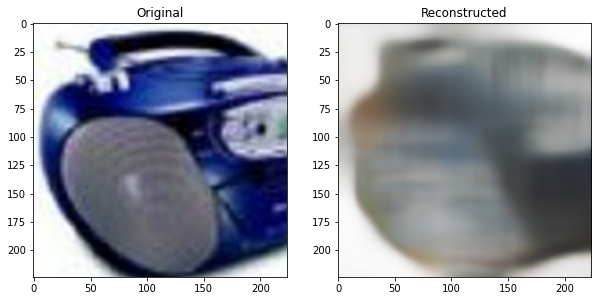

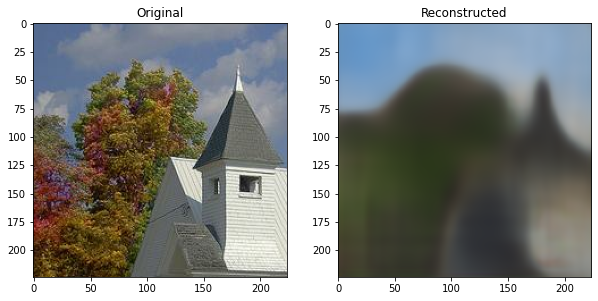

In [0]:
# Plot a couple reconstructions
for image, label in train_data.take(2):
  pretrain_out = pretrained(image)
  reconstruction = lateDeconvNet(pretrain_out[2])
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.imshow(image[0, :, :, :])
  ax1.set_title('Original')
  ax2.imshow(reconstruction[0, :, :, :])
  ax2.set_title('Reconstructed')

In [0]:
#viz_channel = 425 # The feature we want to visualize

# Plot a couple feature visualizations
for image, label in train_data.take(2):
  pretrain_out = pretrained(image)[2]

  # Zero the other channels
  pretrain_out = pretrain_out.numpy()
  # Get maximal activations
  channel_list = [(i, np.median(pretrain_out[:, :, :, i])) for i in range(pretrain_out.shape[3]) ]

  channel_list = sorted(channel_list, reverse=True, key=lambda x: x[1])[:5]
  print(channel_list)

  for viz_channel, mean_activation in channel_list:
    viz_channel = max(channel_list, key=lambda x: x[1])[0]

    pretrain_out[:, :, :, 0:viz_channel] = 0
    pretrain_out[:, :, :, viz_channel+1:] = 0

    reconstruction = lateDeconvNet(pretrain_out)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image[0, :, :, :])
    ax1.set_title('Original')
    ax2.imshow(reconstruction[0, :, :, :])
    ax2.set_title(f'Feature Map {viz_channel}')

NameError: ignored